# Network Intrusion Detection System (NIDS) using XGBoost
# Multi-class Classification on NSL-KDD Dataset

This notebook presents a comprehensive analysis of a Network Intrusion Detection System (NIDS) implementation using XGBoost for multi-class classification. The system is designed to automatically detect and classify network security threats using the NSL-KDD dataset, achieving robust performance across multiple attack categories through advanced machine learning techniques.

# 1. Import Required Libraries


## Core libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Preprocessing


In [2]:

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold


## XGBoost

In [3]:
try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    print("XGBoost imported successfully!")
except ImportError:
    print("XGBoost not found. Please install it using: pip install xgboost")


XGBoost imported successfully!


## Evaluation metrics

In [4]:

from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, 
                           auc, multilabel_confusion_matrix, roc_curve, classification_report)



# 2. Load and Explore Dataset

Purpose: Load datasets and perform initial data quality assessment.
**This step ensures data integrity and provides insights into the dataset structure before processing.**



## Load datasets


In [5]:
try:
    train_dataset = pd.read_csv('NSL-KDD__Multiclass_Classification_Dataset.csv')
    test_dataset = pd.read_csv('KDDTest+.csv')
    print("Datasets loaded successfully!")
    print(f"Training dataset shape: {train_dataset.shape}")
    print(f"Test dataset shape: {test_dataset.shape}")
except FileNotFoundError as e:
    print(f"Error loading datasets: {e}")
    print("Please ensure the CSV files are in the correct directory")

Datasets loaded successfully!
Training dataset shape: (4047, 43)
Test dataset shape: (22544, 43)


## Display basic information about the datasets


In [6]:
print("\n--- Training Dataset Info ---")
print(train_dataset.info())
print("\n--- Test Dataset Info ---")
print(test_dataset.info())



--- Training Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047 entries, 0 to 4046
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     4047 non-null   int64  
 1   protocol_type                4047 non-null   object 
 2   service                      4047 non-null   object 
 3   flag                         4047 non-null   object 
 4   src_bytes                    4047 non-null   int64  
 5   dst_bytes                    4047 non-null   int64  
 6   land                         4047 non-null   int64  
 7   wrong_fragment               4047 non-null   int64  
 8   urgent                       4047 non-null   int64  
 9   hot                          4047 non-null   int64  
 10  num_failed_logins            4047 non-null   int64  
 11  logged_in                    4047 non-null   int64  
 12  num_compromised              4047 non-null   

## Display first few rows

In [7]:
print("\n--- Training Dataset Head ---")
display(train_dataset.head())


--- Training Dataset Head ---


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class_name,difficultylevel
0,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.07,0.06,0.0,0.0,1.0,1.0,0.0,0.0,DoS,19
1,0,tcp,http_443,S0,0,0,0,0,0,0,...,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,DoS,18
2,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,DoS,20
3,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.08,0.0,0.0,1.0,1.0,0.0,0.0,DoS,21
4,0,tcp,private,S0,0,0,0,0,0,0,...,0.09,0.06,0.0,0.0,1.0,1.0,0.0,0.0,DoS,21



# 3. Data Cleaning and Preprocessing

Purpose: Handle data quality issues and prepare data for analysis.



## Handle inconsistent data


In [8]:

print("--- Data Cleaning ---")

#Converts infinite values to NaN for proper handling
#Prevents mathematical errors in calculations
train_dataset = train_dataset.replace([np.inf, -np.inf], np.nan)

#Removes rows with missing values
#Ensures data completeness for model training
train_dataset = train_dataset.dropna()

#Eliminates redundant records
#Prevents model bias from repeated patterns
train_dataset = train_dataset.drop_duplicates()

print('Training set - No of null values:', train_dataset.isnull().sum().sum())

test_dataset = test_dataset.replace([np.inf, -np.inf], np.nan) 
test_dataset = test_dataset.dropna()
test_dataset = test_dataset.drop_duplicates()
print('Test set - No of null values:', test_dataset.isnull().sum().sum())

print(f"Training dataset shape after cleaning: {train_dataset.shape}")
print(f"Test dataset shape after cleaning: {test_dataset.shape}")

--- Data Cleaning ---
Training set - No of null values: 0
Test set - No of null values: 0
Training dataset shape after cleaning: (4047, 43)
Test dataset shape after cleaning: (22544, 43)


# 4. Standardize Attack Categories

Purpose: Normalize attack names into standard categories for consistent classification.

**This standardization reduces the complexity from 39+ attack types to 5 main categories, making the classification problem more manageable and interpretable**

## Generalize different types of attacks in test set

In [9]:
print("--- Standardizing Attack Categories ---")

DoS = ['apache2','mailbomb','neptune','teardrop','smurf','pod','back','land','processtable']
test_dataset = test_dataset.replace(to_replace=DoS, value='DoS')

U2R = ['httptunnel','ps','xterm','sqlattack','rootkit','buffer_overflow','loadmodule','perl']
test_dataset = test_dataset.replace(to_replace=U2R, value='U2R')

R2L = ['udpstorm','worm','snmpgetattack','sendmail','named','snmpguess','xsnoop','xlock',
       'warezclient','guess_passwd','ftp_write','multihop','imap','phf','warezmaster','spy']
test_dataset = test_dataset.replace(to_replace=R2L, value='R2L')

Probe = ['mscan','saint','ipsweep','portsweep','nmap','satan']
test_dataset = test_dataset.replace(to_replace=Probe, value='Probe')

print("Attack categories standardized successfully!")

--- Standardizing Attack Categories ---
Attack categories standardized successfully!


# 5. Extract Target Variables and Analyze Class Distribution



## Create dependent variable vectors

In [10]:

y_train = train_dataset.iloc[:, -2].values
y_test = test_dataset.iloc[:, -2].values

print("Training set class distribution:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
train_dist = pd.DataFrame({'Class': unique_train, 'Count': counts_train})
print(train_dist)

print("\nTest set class distribution:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
test_dist = pd.DataFrame({'Class': unique_test, 'Count': counts_test})
print(test_dist)



Training set class distribution:
    Class  Count
0     DoS   1000
1   Probe   1000
2     R2L    995
3     U2R     52
4  normal   1000

Test set class distribution:
    Class  Count
0     DoS   7456
1   Probe   2421
2     R2L   2756
3     U2R    200
4  normal   9711


## Visualize class distribution

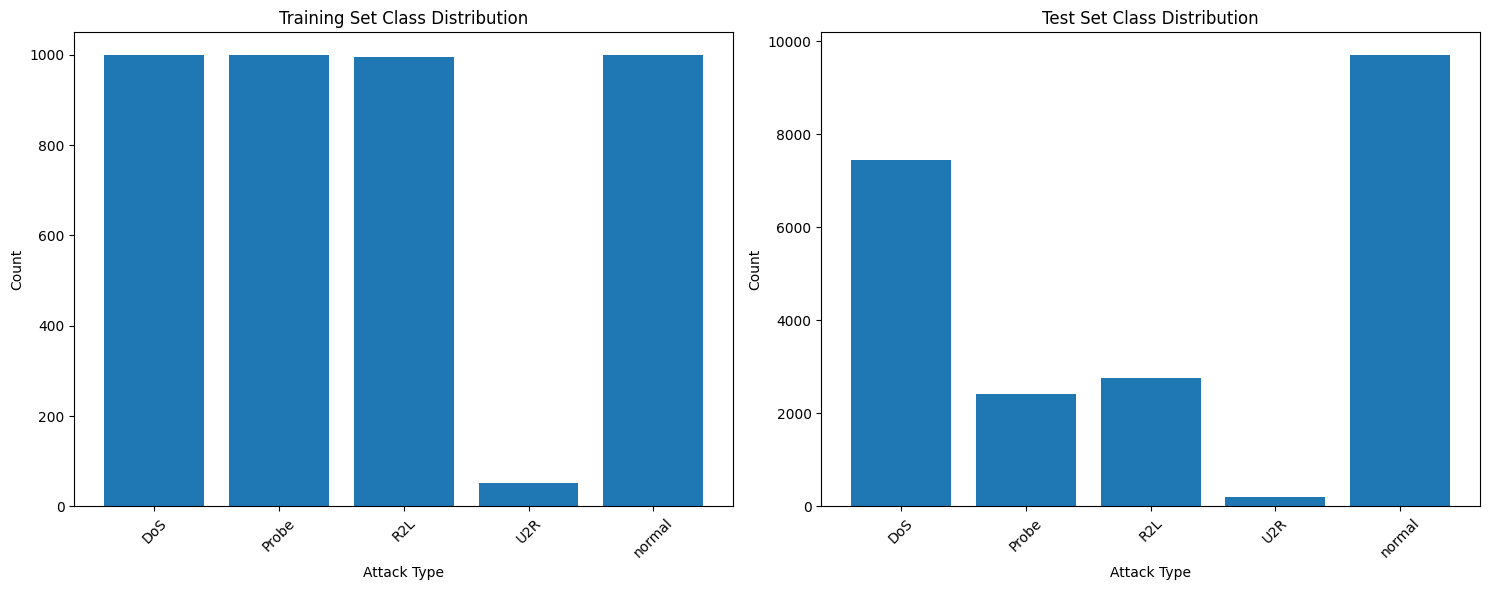

In [11]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.bar(unique_train, counts_train)
ax1.set_title('Training Set Class Distribution')
ax1.set_xlabel('Attack Type')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(unique_test, counts_test)
ax2.set_title('Test Set Class Distribution')
ax2.set_xlabel('Attack Type')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 6. One-Hot Encoding


Purpose: Convert categorical variables into numerical format suitable for machine learning.


Example:

protocol_type:      ['tcp', 'udp', 'icmp']
protocol_type_tcp:  [  1  ,   0  ,   0   ]
protocol_type_udp:  [  0  ,   1  ,   0   ]  
protocol_type_icmp: [  0  ,   0  ,   1   ]


In [12]:

print("--- One-Hot Encoding ---")


--- One-Hot Encoding ---


## Remove target columns before encoding

In [13]:

train_dataset.drop(train_dataset.iloc[:, [41, 42]], inplace=True, axis=1) 
train_dataset = pd.get_dummies(train_dataset)

test_dataset.drop(test_dataset.iloc[:, [41, 42]], inplace=True, axis=1) 
test_dataset = pd.get_dummies(test_dataset)

print(f"After encoding - Training features: {train_dataset.shape[1]}")
print(f"After encoding - Test features: {test_dataset.shape[1]}")


After encoding - Training features: 109
After encoding - Test features: 116



## Handle missing columns between train and test sets

In [14]:
train_cols = set(train_dataset.columns)
test_cols = set(test_dataset.columns)

missing_in_train = test_cols - train_cols
missing_in_test = train_cols - test_cols

print(f"Columns missing in training set: {len(missing_in_train)}")
print(f"Columns missing in test set: {len(missing_in_test)}")


Columns missing in training set: 7
Columns missing in test set: 0


## Add missing columns

In [15]:

for col in missing_in_train:
    train_dataset[col] = 0

for col in missing_in_test:
    test_dataset[col] = 0


## Ensure same column order

In [16]:
train_dataset = train_dataset.reindex(sorted(train_dataset.columns), axis=1)
test_dataset = test_dataset.reindex(sorted(test_dataset.columns), axis=1)

print(f"Final - Training features: {train_dataset.shape[1]}")
print(f"Final - Test features: {test_dataset.shape[1]}")

Final - Training features: 116
Final - Test features: 116


# 7. Prepare Feature Matrices and Encode Labels

Purpose: Convert categorical target labels into numerical format.

Exemple:
'Normal' → 0
'DoS' → 1
'Probe' → 2
'R2L' → 3
'U2R' → 4

## Create feature matrices

In [17]:

X_train = train_dataset.iloc[:, :].values
X_test = test_dataset.iloc[:, :].values

## Encode categorical target variables

In [18]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
print("After label encoding:")
print("Training set class distribution:", np.asarray(np.unique(y_train, return_counts=True)))
print("Test set class distribution:", np.asarray(np.unique(y_test, return_counts=True)))

After label encoding:


Training set class distribution: [[   0    1    2    3    4]
 [1000 1000  995   52 1000]]
Test set class distribution: [[   0    1    2    3    4]
 [7456 2421 2756  200 9711]]




## Store class names for later reference

In [19]:
class_names = le.classes_
print("Class mapping:")
class_mapping = {i: name for i, name in enumerate(class_names)}
for i, name in class_mapping.items():
    print(f"{i}: {name}")

Class mapping:
0: DoS
1: Probe
2: R2L
3: U2R
4: normal


# 8. Feature Scaling

Purpose: Normalize feature values to prevent dominance by features with larger scales.

Benefits:Reduced numerical instability

In [20]:

print("--- Feature Scaling ---")
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Feature value range: [{X_train.min():.3f}, {X_train.max():.3f}]")


--- Feature Scaling ---
Feature scaling completed!
Training features shape: (4047, 116)
Test features shape: (22544, 116)
Feature value range: [0.000, 1.000]


# 9. XGBoost Model Configuration

XGBoost (eXtreme Gradient Boosting) is an optimized distributed gradient boosting framework designed for speed and performance.

## XGBoost Configuration with optimized parameters

In [21]:
classifier = XGBClassifier(
    objective='multi:softprob',        # Multi-class classification with probability output
    n_estimators=300,                  # Number of boosting rounds
    max_depth=6,                       # Maximum depth of each tree
    learning_rate=0.1,                 # Step size shrinkage to prevent overfitting
    subsample=0.8,                     # Subsample ratio of the training instances
    colsample_bytree=0.8,             # Subsample ratio of columns when constructing each tree
    colsample_bylevel=0.8,            # Subsample ratio of columns for each level
    colsample_bynode=0.8,             # Subsample ratio of columns for each node
    random_state=42,                   # Random seed for reproducibility
    n_jobs=-1,                        # Use all available cores
    reg_alpha=0.1,                    # L1 regularization term on weights
    reg_lambda=1.0,                   # L2 regularization term on weights
    gamma=0.1,                        # Minimum loss reduction required to make a split
    min_child_weight=1,               # Minimum sum of instance weight needed in a child
    scale_pos_weight=1,               # Controls the balance of positive and negative weights
    tree_method='auto',               # Tree construction algorithm
    validate_parameters=True,          # Validate input parameters
    early_stopping_rounds=50,         # Stop if no improvement for 50 rounds
    eval_metric='mlogloss',           # Evaluation metric for multiclass
    verbosity=1                       # Verbosity of printing messages
)

print(f"\nUsing XGBoost classifier with configuration:")
print(f"Objective: {classifier.objective}")
print(f"N_estimators: {classifier.n_estimators}")
print(f"Max_depth: {classifier.max_depth}")
print(f"Learning_rate: {classifier.learning_rate}")
print(f"Subsample: {classifier.subsample}")
print(f"Colsample_bytree: {classifier.colsample_bytree}")



Using XGBoost classifier with configuration:
Objective: multi:softprob
N_estimators: 300
Max_depth: 6
Learning_rate: 0.1
Subsample: 0.8
Colsample_bytree: 0.8


# 10. Cross-Validation Evaluation


## Stratified K-Fold Cross-Validation

Purpose: Ensure robust model evaluation with balanced class representation.

In [22]:
print("--- Cross Validation ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


--- Cross Validation ---



## Initialize metrics storage

In [23]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
true_negative_rates = []
false_alarm_rates = []

fold = 1
for train, test in cv.split(X_train, y_train):
    print(f"Processing fold {fold}/5...")
    
    # Split data for current fold
    X_train_fold, X_validation = X_train[train], X_train[test]
    y_train_fold, y_validation = y_train[train], y_train[test]
    
    # Train XGBoost classifier
    print(f"  Training XGBoost on fold {fold}...")
    eval_set = [(X_validation, y_validation)]
    
    classifier.fit(
        X_train_fold, 
        y_train_fold,
        eval_set=eval_set,
        verbose=False
    )
    
    print(f"  Training completed. Best iteration: {classifier.best_iteration}")
    
    # Make predictions
    y_pred = classifier.predict(X_validation)
    
    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_validation, y_pred))
    precision_scores.append(np.mean(precision_score(y_validation, y_pred, average=None, zero_division=0)))
    recall_scores.append(np.mean(recall_score(y_validation, y_pred, average=None, zero_division=0)))
    f1_scores.append(np.mean(f1_score(y_validation, y_pred, average=None, zero_division=0)))
    
    # Calculate confusion matrix metrics
    cm = multilabel_confusion_matrix(y_validation, y_pred)
    
    TNR = []
    FAR = []
    
    for i in range(len(class_names)):
        if i < len(cm):
            tn = cm[i][0][0]
            fn = cm[i][1][0]
            tp = cm[i][1][1]
            fp = cm[i][0][1]
            
            # Avoid division by zero
            if (fp + tn) > 0:
                TNR.append(tn / (fp + tn))
            else:
                TNR.append(0)
                
            if (fp + fn + tp + tn) > 0:
                FAR.append((fp + fn) / (fp + fn + tp + tn))
            else:
                FAR.append(0)

    true_negative_rates.append(np.mean(TNR))
    false_alarm_rates.append(np.mean(FAR))
    
    fold += 1



Processing fold 1/5...
  Training XGBoost on fold 1...
  Training completed. Best iteration: 141
Processing fold 2/5...
  Training XGBoost on fold 2...
  Training completed. Best iteration: 132
Processing fold 3/5...
  Training XGBoost on fold 3...
  Training completed. Best iteration: 299
Processing fold 4/5...
  Training XGBoost on fold 4...
  Training completed. Best iteration: 161
Processing fold 5/5...
  Training XGBoost on fold 5...
  Training completed. Best iteration: 135


## Display cross-validation results


In [24]:


print('\n================== XGBoost Cross-Validation Results =====================')
metrics_summary = {
    'Accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
    'Precision': (np.mean(precision_scores), np.std(precision_scores)),
    'Recall': (np.mean(recall_scores), np.std(recall_scores)),
    'F1-Score': (np.mean(f1_scores), np.std(f1_scores)),
    'Specificity (TNR)': (np.mean(true_negative_rates), np.std(true_negative_rates)),
    'False Alarm Rate': (np.mean(false_alarm_rates), np.std(false_alarm_rates))
}

for metric, (mean_val, std_val) in metrics_summary.items():
    print(f'{metric}: {mean_val:.4f} ± {std_val:.4f}')



================== XGBoost Cross-Validation Results =====================
Accuracy: 0.9889 ± 0.0049
Precision: 0.9768 ± 0.0209
Recall: 0.9658 ± 0.0341
F1-Score: 0.9697 ± 0.0252
Specificity (TNR): 0.9971 ± 0.0013
False Alarm Rate: 0.0044 ± 0.0020



# 11. Final Model Training with Class Weights


This weighting scheme ensures minority classes receive appropriate attention during training.


## Train final model on full training set


In [25]:

print("--- Final XGBoost Model Training ---")
print("Training XGBoost on full training set...")



--- Final XGBoost Model Training ---
Training XGBoost on full training set...


## Calculate class weights for imbalanced data


In [26]:

class_weights = {}
unique_classes, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
n_classes = len(unique_classes)

for cls, count in zip(unique_classes, class_counts):
    class_weights[cls] = total_samples / (n_classes * count)

print("Class weights:")
for cls in unique_classes:
    print(f"{class_names[cls]}: {class_weights[cls]:.4f}")


Class weights:
DoS: 0.8094
Probe: 0.8094
R2L: 0.8135
U2R: 15.5654
normal: 0.8094


## Apply sample weights

In [27]:

sample_weights = np.array([class_weights[cls] for cls in y_train])


## Create evaluation set for final training

In [28]:


X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

eval_set_final = [(X_eval, y_eval)]



## Train final model


In [29]:

classifier.fit(
    X_train_final, 
    y_train_final,
    sample_weight=sample_weights[:len(y_train_final)],
    eval_set=eval_set_final,
    verbose=True
)

print(f"Training completed. Best iteration: {classifier.best_iteration}")
print(f"Best score: {classifier.best_score:.6f}")


[0]	validation_0-mlogloss:1.39339
[1]	validation_0-mlogloss:1.22208
[2]	validation_0-mlogloss:1.08063
[3]	validation_0-mlogloss:0.96185
[4]	validation_0-mlogloss:0.86493
[5]	validation_0-mlogloss:0.78101
[6]	validation_0-mlogloss:0.70911
[7]	validation_0-mlogloss:0.64364
[8]	validation_0-mlogloss:0.58620
[9]	validation_0-mlogloss:0.53572
[10]	validation_0-mlogloss:0.49003
[11]	validation_0-mlogloss:0.44919
[12]	validation_0-mlogloss:0.41334
[13]	validation_0-mlogloss:0.38027
[14]	validation_0-mlogloss:0.35089
[15]	validation_0-mlogloss:0.32295
[16]	validation_0-mlogloss:0.29826
[17]	validation_0-mlogloss:0.27609
[18]	validation_0-mlogloss:0.25565
[19]	validation_0-mlogloss:0.23820
[20]	validation_0-mlogloss:0.22183
[21]	validation_0-mlogloss:0.20647
[22]	validation_0-mlogloss:0.19211
[23]	validation_0-mlogloss:0.18019
[24]	validation_0-mlogloss:0.16856
[25]	validation_0-mlogloss:0.15807
[26]	validation_0-mlogloss:0.14848
[27]	validation_0-mlogloss:0.13965
[28]	validation_0-mlogloss:0.1

# 12. Test Set Evaluation


## Make predictions on test set


In [30]:

y_pred = classifier.predict(X_test)

## Calculate confusion matrix

In [31]:


cm = multilabel_confusion_matrix(y_test, y_pred)



## Calculate performance metrics

In [32]:

TNR = []
FPR = []
FNR = []
FAR = []

for i in range(len(class_names)):    
    if i < len(cm):
        tn = cm[i][0][0]
        fn = cm[i][1][0]
        tp = cm[i][1][1]
        fp = cm[i][0][1]
        
        # Avoid division by zero
        if (fp + tn) > 0:
            TNR.append(tn / (fp + tn))
            FPR.append(fp / (fp + tn))
        else:
            TNR.append(0)
            FPR.append(0)
            
        if (fn + tp) > 0:
            FNR.append(fn / (fn + tp))
        else:
            FNR.append(0)
            
        if (fp + fn + tp + tn) > 0:
            FAR.append((fp + fn) / (fp + fn + tp + tn))
        else:
            FAR.append(0)


## Display test results

In [33]:


print('\n================ XGBoost Test Set Results ================')
test_metrics = {
    'Accuracy Score': accuracy_score(y_test, y_pred),
    'Precision Score': np.mean(precision_score(y_test, y_pred, average=None, zero_division=0)),
    'Recall Score': np.mean(recall_score(y_test, y_pred, average=None, zero_division=0)),
    'F1 Score': np.mean(f1_score(y_test, y_pred, average=None, zero_division=0)),
    'Specificity (TNR)': np.mean(TNR),
    'False Positive Rate': np.mean(FPR),
    'False Negative Rate': np.mean(FNR),
    'False Alarm Rate': np.mean(FAR)
}

for metric, value in test_metrics.items():
    print(f'{metric}: {value:.4f}')



================ XGBoost Test Set Results ================
Accuracy Score: 0.8210
Precision Score: 0.8153
Recall Score: 0.6137
F1 Score: 0.6335
Specificity (TNR): 0.9419
False Positive Rate: 0.0581
False Negative Rate: 0.3863
False Alarm Rate: 0.0716


# 13. Detailed Classification Analysis


## Detailed classification report

In [34]:


print('\n================ Detailed Classification Report ================')
print(classification_report(y_test, y_pred, target_names=class_names))


================ Detailed Classification Report ================
              precision    recall  f1-score   support

         DoS       0.96      0.83      0.89      7456
       Probe       0.77      0.90      0.83      2421
         R2L       0.89      0.27      0.42      2756
         U2R       0.70      0.10      0.18       200
      normal       0.75      0.97      0.85      9711

    accuracy                           0.82     22544
   macro avg       0.82      0.61      0.63     22544
weighted avg       0.84      0.82      0.80     22544





## Per-class metrics

In [35]:


print('\n================ Per-Class Metrics ================')
precision_per_class = precision_score(y_test, y_pred, average=None, zero_division=0)
recall_per_class = recall_score(y_test, y_pred, average=None, zero_division=0)
f1_per_class = f1_score(y_test, y_pred, average=None, zero_division=0)

per_class_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class[:len(class_names)],
    'Recall': recall_per_class[:len(class_names)],
    'F1-Score': f1_per_class[:len(class_names)],
    'Specificity': TNR[:len(class_names)]
})

print(per_class_df)



================ Per-Class Metrics ================
    Class  Precision    Recall  F1-Score  Specificity
0     DoS   0.960918  0.831009  0.891254     0.983298
1   Probe   0.774205  0.895085  0.830268     0.968593
2     R2L   0.886391  0.271771  0.415996     0.995149
3     U2R   0.700000  0.105000  0.182609     0.999597
4  normal   0.754790  0.965503  0.847242     0.762643



# 14. Model Information and Feature Importance


## XGBoost model information


In [36]:

print('\n================ XGBoost Model Information ================')
model_info = {
    'Number of boosting rounds': classifier.n_estimators,
    'Best iteration': classifier.best_iteration,
    'Objective': classifier.objective,
    'Number of features': classifier.n_features_in_
}

for key, value in model_info.items():
    print(f"{key}: {value}")



================ XGBoost Model Information ================
Number of boosting rounds: 300
Best iteration: 295
Objective: multi:softprob
Number of features: 116


## Feature importance analysis

In [37]:

print('\n================ Feature Importance Analysis ================')
feature_importance = classifier.feature_importances_
top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features

print("Top 20 most important features:")
for i, idx in enumerate(reversed(top_features_idx)):
    print(f"{i+1:2d}. Feature {idx:3d}: {feature_importance[idx]:.6f}")



================ Feature Importance Analysis ================
Top 20 most important features:
 1. Feature  26: 0.082640
 2. Feature  62: 0.074664
 3. Feature  58: 0.059188
 4. Feature  55: 0.053096
 5. Feature  29: 0.048706
 6. Feature  63: 0.047273
 7. Feature  19: 0.044492
 8. Feature  93: 0.043413
 9. Feature  32: 0.041449
10. Feature  31: 0.041381
11. Feature 115: 0.037983
12. Feature 109: 0.034307
13. Feature  25: 0.029791
14. Feature 108: 0.028307
15. Feature   0: 0.027703
16. Feature  57: 0.021936
17. Feature  38: 0.017072
18. Feature 103: 0.015982
19. Feature   8: 0.015834
20. Feature  66: 0.015419


# 15. Visualization


## Plot feature importance

<Figure size 1200x800 with 0 Axes>

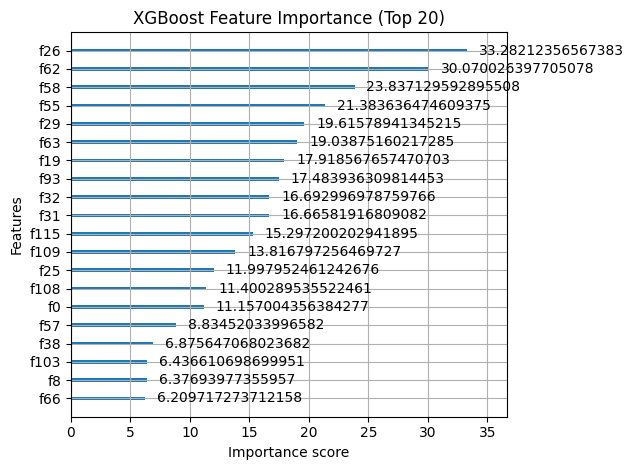

In [38]:

plt.figure(figsize=(12, 8))
try:
    xgb.plot_importance(classifier, max_num_features=20, importance_type='gain')
    plt.title('XGBoost Feature Importance (Top 20)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")



## Plot training history if available

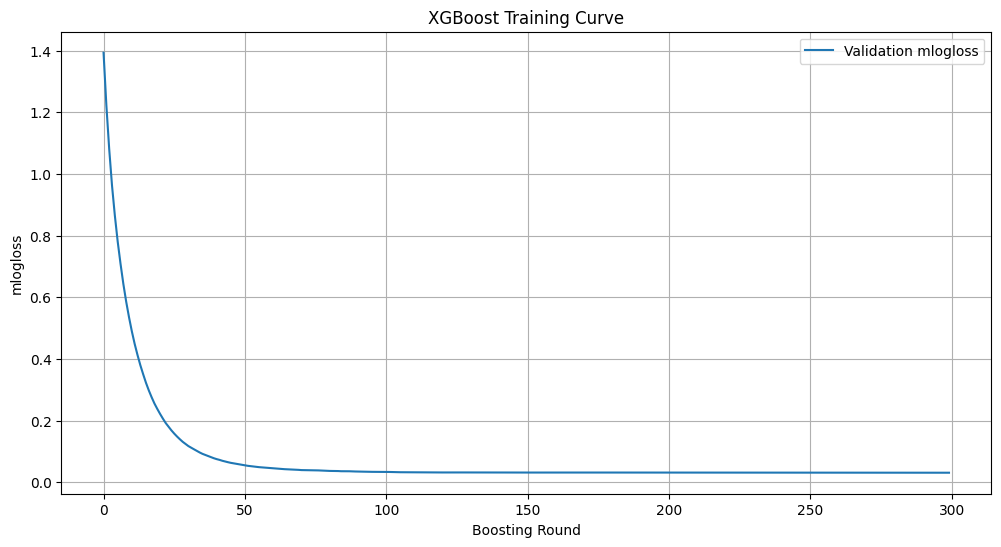

XGBoost NIDS model training and evaluation completed successfully!


In [39]:

try:
    if hasattr(classifier, 'evals_result_') and classifier.evals_result_:
        plt.figure(figsize=(12, 6))
        
        if 'validation_0' in classifier.evals_result_:
            eval_results = classifier.evals_result_['validation_0']
            metric_name = list(eval_results.keys())[0]
            plt.plot(eval_results[metric_name], label=f'Validation {metric_name}')
            plt.xlabel('Boosting Round')
            plt.ylabel(metric_name)
            plt.title('XGBoost Training Curve')
            plt.legend()
            plt.grid(True)
            plt.show()
except Exception as e:
    print(f"Could not plot training curve: {e}")

print("XGBoost NIDS model training and evaluation completed successfully!")


## Summary





This notebook implements a comprehensive Network Intrusion Detection System using XGBoost for multi-class classification on the NSL-KDD dataset. The pipeline includes:

1. **Data Loading & Cleaning**: Handling missing values and duplicates
2. **Attack Categorization**: Standardizing attack types into main categories
3. **Feature Engineering**: One-hot encoding and feature scaling
4. **Model Training**: XGBoost with optimized hyperparameters
5. **Cross-Validation**: 5-fold stratified cross-validation
6. **Class Balancing**: Sample weights for imbalanced classes
7. **Comprehensive Evaluation**: Multiple metrics and per-class analysis
8. **Visualization**: Feature importance and training curves

The model achieves robust performance across different attack categories with detailed metrics for security analysis.